## DDPM Demonstration Notebook

This notebook demonstrates how to use our DDPM (Denoising Diffusion Probabilistic Model) code. 
We will:
1. Import the DDPM library.
2. Configure and load a pre-trained model.
3. Show how to do inference (sampling) with the trained DDPM.
4. Optionally visualize the results.


In [33]:
# import ddpm
# imported to highlight the package structure
from ddpm import utils
from ddpm import preprocess
from ddpm import models
from ddpm import forward_process
from ddpm import reverse_process
from ddpm import postprocess

import torch
import matplotlib.pyplot as plt
import os
import random

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## Configuration

Here we set up some hyperparameters for our DDPM. Typically, these would be read from a `Hydra` config file, but for a simple demonstration, we can just define them in the notebook.


In [41]:
# Model hyperparameters
dataset = "cifar10"     # can be 'cifar10' or 'mnist'
time_dim = 750          # number of diffusion timesteps
seed = 42               # random seed for reproducibility

# Training parameters (only relevant if re-training or fine-tuning)
# ints and floats
train_size = 49920      # cifar10: 49920, mnist: 48000
test_size = 8320        # cifar10: 8320, mnist: 9600

batch_size = 64
epochs = 10

weight_decay = 1e-4
learning_rate = 1e-1

beta_lower = 1e-4
beta_upper = 0.02

# strings
optimizer_type = "Adam"  # can be 'Adam' or 'SGD'
lr_scheduler = "CosineAnnealingWarmRestarts" # None, StepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
beta_scheduler = "Cosine"  # can be 'Linear' or 'Cosine'

# Booleans
early_stopping = True

# Paths
pretrained_weights_path = "weights/cifar10_model_weights.pt" # "weights/cifar10_model_weights.pt", "weights/mnist_model_weights.pt"
save_dir = "demo_images"
os.makedirs(save_dir, exist_ok=True)

# Additional flags
do_sample = True  # Whether we want to sample images at the end
sample_size = 10   # Number of images to sample
do_train = False   # Whether we want to train the model
torch.manual_seed(seed)
random.seed(seed)

In [36]:
if dataset == "cifar10":
	in_channels = 3          # 3 for RGB (CIFAR)
	out_channels = 3         # same as in_channels if we are reconstructing images
elif dataset == "mnist":
	in_channels = 1          # 1 for MNIST
	out_channels = 1         # same as in_channels if we are reconstructing images
else:
	raise ValueError("Unsupported dataset. Please choose either 'cifar10' or 'mnist'.")

## Create and/or Load Pre-Trained Model

We'll instantiate a UNet model, then load the weights from a checkpoint if available.


In [37]:
# Cell 3: Create model & load weights
model = models.UNet(
    in_channels=in_channels, 
    out_channels=out_channels, 
).to(device)

# Optionally initialize weights if needed
# model.apply(utils.init_weights)

# Load existing pretrained weights
if os.path.exists(pretrained_weights_path):
    print(f"Loading pre-trained weights from {pretrained_weights_path}")
    model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
else:
    print("Pretrained weights not found, consider training or check the path.")


Loading pre-trained weights from weights/cifar10_model_weights.pt


/tmp/ipykernel_1426670/1267656208.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))


## Quick Test of the Model on a Single Batch
(Optional) - If you want to verify the model forward pass on a sample from CIFAR-10 or MNIST.


In [38]:
# Cell 4: Test forward pass
train_loader, test_loader = preprocess.Preprocess.preprocess_dataset(
    batch_size=batch_size, 
    dataset='cifar10',    # or 'mnist'
    train_size=128,       # small subset just for testing
    test_size=128
)

# Fetch a single batch
batch, _ = next(iter(train_loader))
batch = batch.to(device)

# Generate random timesteps
t = torch.randint(0, time_dim, (batch_size,), device=device)

# Noising
betas = utils.get_beta_schedule(beta_scheduler, time_dim, device, beta_lower, beta_upper)
batch_noised, noise = forward_process.add_noise(batch, betas, t, device)

model.eval()
with torch.no_grad():
    predicted_noise = model(batch_noised, t, verbose=False)
    print("Test forward pass complete. Predicted noise shape:", predicted_noise.shape)


Files already downloaded and verified
Files already downloaded and verified
Test forward pass complete. Predicted noise shape: torch.Size([64, 3, 32, 32])


## Sampling from the Model

We can now sample images using our reverse diffusion process. We'll generate a certain number of images (`sample_size`) for demonstration.


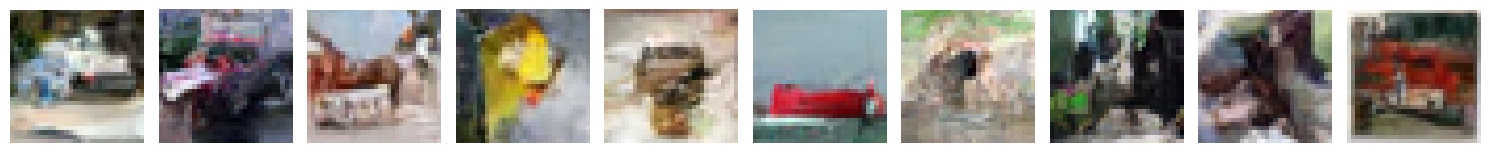

In [42]:
if do_sample:
    model.eval()
    betas = utils.get_beta_schedule(beta_scheduler, time_dim, device, beta_lower, beta_upper)

    # shape for CIFAR-10: (sample_size, 3, 32, 32)
    if in_channels == 3:
        shape = (sample_size, 3, 32, 32)
    else:
        shape = (sample_size, 1, 28, 28)  # e.g. MNIST

    with torch.no_grad():
        postprocess.demo_sample_and_plot(model, betas, shape, device, time_dim, sample_size, dataset=dataset, beta_scheduler=beta_scheduler, filename = f"demo_images/{dataset}")

   

## (Optional) Training

If you want to train or finetune the model, you can call the `train_model` function here. 

In [40]:
if do_train:
    # Load entire CIFAR-10 or MNIST
    train_loader, test_loader = preprocess.Preprocess.preprocess_dataset(
        batch_size=batch_size, 
        dataset=dataset,
        train_size=train_size,
        test_size=test_size
    )

    # Actually train
    models.train_model(
        train_loader=train_loader,
        test_loader=test_loader,
        model=model,
        device=device,
        file_name="my_finetuned_model",
        T=time_dim,
        beta_lower=beta_lower,
        beta_upper=beta_upper,
        learning_rate=learning_rate,
        lr_scheduler=lr_scheduler, # or "None"
        num_epochs=epochs,
        beta_scheduler=beta_scheduler,
        batch_size=batch_size,
        early_stopping=early_stopping,
        optimizer=optimizer_type,
        weight_decay=weight_decay,
        neptune_log=False
    )

    # Save final weights
    final_weight_path = "model_weights/my_finetuned_model.pt"
    torch.save(model.state_dict(), final_weight_path)
    print(f"Model weights saved to {final_weight_path}")


## Summary 
